In [1]:
import pandas as pd
import numpy as np
import pycountry
from scipy.optimize import least_squares
import random
import statsmodels
from scipy.optimize import minimize
from scipy.optimize import fsolve
from pandas.core import datetools
import statsmodels.api as sm
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from collections import defaultdict
from math import pi, e

/home/sara/myenv/lib64/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  if __name__ == '__main__':


In [2]:
resident_foreigners_norm = pd.read_table("Data_final/resident_foreigners_norm.csv")

province_capitals = ['Ancona', "Valle d'Aosta / Vallée d'Aoste", "L'Aquila", 'Bari', 'Bologna', 'Cagliari', 'Campobasso', 'Catanzaro', 'Firenze', 'Genova', 'Milano', 'Napoli', 'Palermo', 'Perugia', 'Potenza', 'Roma', 'Torino', 'Trento', 'Trieste', 'Venezia']
# Untill 2011 - in 2011 change
years = list(range(2004, 2016))

In [3]:
resident_foreigners_norm.head()

,Province,Country,Year,Gender,Value
0,Biella,AND,2005,male,1
1,Biella,AND,2005,female,0
2,Novara,AND,2005,male,0
3,Novara,AND,2005,female,2
4,Alessandria,AND,2017,male,0


In [4]:
regions = pd.read_table("Data_final/regioni.csv")
regions_info = pd.read_table("Data_final/region_info.csv")

prov_info = pd.read_table("Data_final/prov_cap_info.csv")

mezzogiorno = {'Abruzzo': 1, 'Lazio': 0, 'Umbria': 0, 'Provincia Autonoma Trento': 0, 
               'Friuli-Venezia Giulia': 0, 'Molise': 1, 'Calabria': 1, 
               "Valle d'Aosta / Vallée d'Aoste": 0, 'Lombardia': 0, 'Liguria': 0, 
               'Emilia-Romagna': 0, 'Sicilia': 1, 
               'Provincia Autonoma Bolzano / Bozen': 0, 'Puglia': 1, 'Campania': 1, 
               'Piemonte': 0, 'Toscana': 0, 'Sardegna': 1, 'Marche': 0, 
               'Basilicata': 1, 'Veneto': 0}

In [5]:
x_df = pd.DataFrame()
x_df = prov_info[["Prov Capitals", "Area", "Dens"]].copy()
# Logarithmic transformation
x_df["Area"] = np.log(x_df["Area"])
x_df["Dens"] = np.log(x_df["Dens"])
x_df["Mezzogiorno"] = [mezzogiorno[regions[regions["Provincia"] == i]["Regione"].values[0]] for i in x_df["Prov Capitals"].values]

In [6]:
x_df.head()

,Prov Capitals,Area,Dens,Mezzogiorno
0,Ancona,7.582341,5.488938,0
1,Valle d'Aosta / Vallée d'Aoste,8.089759,3.663562,0
2,L'Aquila,8.526658,4.094345,1
3,Bari,8.259168,5.786897,1
4,Bologna,8.216715,5.609472,0


In [7]:
data = resident_foreigners_norm.copy()
data = resident_foreigners_norm[(resident_foreigners_norm["Province"].isin(province_capitals)) & 
                                (resident_foreigners_norm["Year"].isin(years))]
data = data.groupby(["Province", "Country", "Year"], as_index=False).sum()

In [8]:
data_rou = data[data["Country"] == pycountry.countries.get(name="Romania").alpha_3]
del data_rou["Country"]
data_alb = data[data["Country"] == pycountry.countries.get(name="Albania").alpha_3]
del data_alb["Country"]
data_mar = data[data["Country"] == pycountry.countries.get(name="Morocco").alpha_3]
del data_mar["Country"]

In [9]:
# Get the foreigners stock value
def n_it(data_, i, t):
    return(data_[(data_["Province"] == i) & (data_["Year"] == t)]["Value"].values[0])

In [10]:
# Fill with 0 missing values
def missing_values(data_, times, territories):
    for i in territories:
        for t in times:
            try:
                temp = data_[(data_["Province"] == i) & (data_["Year"] == t)]["Value"].values[0]
            except IndexError:
                data_ = data_.append({"Province": i, "Year": t, "Value": 0}, ignore_index=True)
    return(data_)

In [11]:
# Handle missing values
data_rou = missing_values(data_rou, years, province_capitals)
data_alb = missing_values(data_alb, years, province_capitals)
data_mar = missing_values(data_mar, years, province_capitals)

## Step I

In [12]:
# Define the normal regression model

def stepI(param, data_, time):
    log_lik = 0
    
    beta = param[0]
    a = param[1:]
    
    for i in province_capitals:
        for t in time[1:]:
            log_lik += (np.log(n_it(data_, i, t)) - beta*(np.log(n_it(data_, i, t-1))) - a[province_capitals.index(i)])**2 

    return(log_lik)

## Step II

In [13]:
def stepII(theta, a, x_):
    log_lik = 0
    #x_I = x_[x_["Prov Capitals"] == I][["Area", "Dens", "Mezzogiorno"]].values
    for i in province_capitals:
        x_i = x_[x_["Prov Capitals"] == i][["Area", "Dens", "Mezzogiorno"]].values
        log_lik += (a[province_capitals.index(i)] - np.dot(x_i, theta))**2
    return(log_lik)

# Run the different models for the different origin country

In [14]:
def run_model(data_, time, x_):
    print("---------- Step I ----------")
    initial_time = datetime.datetime.now()
    print ("Current time: " + str(initial_time.strftime('%H:%M:%S') ))

    #param_init = np.random.uniform(0, 1, len(province_capitals)+1)
    param_init = [0 for i in range(len(province_capitals)+1)]
    res_stepI =  minimize(stepI, param_init, args = (data_, time), method='CG')
    print(res_stepI.message)
    
    final_time = datetime.datetime.now() 
    print ("Current time: " + str(final_time.strftime('%H:%M:%S')))
    print("Computational time: " + str((final_time - initial_time)))
    
    # Step I results and validation
    beta_hat = res_stepI.x[0]
    a_hat = res_stepI.x[1:]
    y_hat = []
    y = []
    for i in province_capitals:
        time_invariant = a_hat[province_capitals.index(i)]
        for t in time[1:]:
            y.append(np.log(n_it(data_, i, t)))
            y_hat.append(beta_hat*(np.log(n_it(data_, i, t-1))) + time_invariant)
            
    y_mean = np.mean(y)

    R2 = 1 - sum(np.subtract(y, y_hat)**2) / sum((y - y_mean)**2)
    # Equivalently: 1 - (res_stepI.fun / sum((y - y_mean)**2))
    #print(R2)
    print("The R2 score from the step I is: %f" %R2)
    
    #return(beta_hat, a_hat)
    
    print("---------- Step II ----------")
    
    initial_time = datetime.datetime.now()
    print ("Current time: " + str(initial_time.strftime('%H:%M:%S') ))

    param_init = [0 for i in range(len(x_.columns)-1)]
    #param_init = np.random.uniform(0, 1, len(x_df.columns)-1)
    res_stepII =  minimize(stepII, param_init, args = (a_hat, x_), method='CG')
    #print(model_I([b, a], data_rou), b, a)
    #print(res_stepII.x)
    print(res_stepII.message)
    #print(res_stepII.fun)
    final_time = datetime.datetime.now() 
    print ("Current time: " + str(final_time.strftime('%H:%M:%S')))
    print("Computational time: " + str((final_time - initial_time)))
    
    # Step II results and validation
    theta_hat = res_stepII.x
    #x_I = x_[x_["Prov Capitals"] == I][["Area", "Dens", "Mezzogiorno"]].values
    y_hat = []
    #y = []
    for i in province_capitals:
        x_i = x_[x_["Prov Capitals"] == i][["Area", "Dens", "Mezzogiorno"]].values
        time_invariant = np.dot(x_i, theta_hat)
        for t in time[1:]:
            #y.append(np.log(n_it(data_, i, t)/n_it(data_, I, t)))
            y_hat.append((beta_hat*(np.log(n_it(data_, i, t-1))) + time_invariant)[0])
            
    #y_mean = np.mean(y)
    R2 = 1 - sum(np.subtract(y, y_hat)**2) / sum((y - y_mean)**2)
    #print(R2)
    print("The final R2 score is: %f" %R2)
    
    n = len(y)
    k = len(x_.columns)-1
    R2_adj = 1 - (1 - R2)*((n - 1)/(n - k -1))
    print("The final Adjusted R2 score is: %f" %R2_adj)
    
    return(beta_hat, theta_hat, y, y_hat)

In [15]:
res_rou = run_model(data_rou, years, x_df)

---------- Step I ----------
Current time: 12:36:00
Desired error not necessarily achieved due to precision loss.
Current time: 12:59:12
Computational time: 0:23:11.252839
The R2 score from the step I is: 0.974474
---------- Step II ----------
Current time: 12:59:12
Optimization terminated successfully.
Current time: 12:59:13
Computational time: 0:00:00.924224
The final R2 score is: 0.971568
The final Adjusted R2 score is: 0.971173


In [16]:
print("Beta parameter: %f" %res_rou[0])
print("Theta parameter: %s %s %s" %tuple(res_rou[1]))

Beta parameter: 0.833746
Theta parameter: 0.1446869875 0.0927882084689 -0.157863986658


In [17]:
res_alb = run_model(data_alb, years, x_df)

---------- Step I ----------
Current time: 13:04:13
Desired error not necessarily achieved due to precision loss.
Current time: 13:14:18
Computational time: 0:10:05.533706
The R2 score from the step I is: 0.998856
---------- Step II ----------
Current time: 13:14:19
Optimization terminated successfully.
Current time: 13:14:20
Computational time: 0:00:00.926648
The final R2 score is: 0.978592
The final Adjusted R2 score is: 0.978295


In [18]:
print("Beta parameter: %f" %res_alb[0])
print("Theta parameter: %s %s %s" %tuple(res_alb[1]))

Beta parameter: 0.741062
Theta parameter: 0.198850834409 0.129249541653 -0.537740896231


In [19]:
res_mar = run_model(data_mar, years, x_df)

---------- Step I ----------
Current time: 13:14:21
Desired error not necessarily achieved due to precision loss.
Current time: 13:27:04
Computational time: 0:12:43.448873
The R2 score from the step I is: 0.996327
---------- Step II ----------
Current time: 13:27:05
Optimization terminated successfully.
Current time: 13:27:06
Computational time: 0:00:01.034350
The final R2 score is: 0.988823
The final Adjusted R2 score is: 0.988667


In [20]:
print("Beta parameter: %f" %res_mar[0])
print("Theta parameter: %s %s %s" %tuple(res_mar[1]))

Beta parameter: 0.840792
Theta parameter: 0.133390655454 0.0590865150605 -0.165941419894


In [23]:
def real_vs_prediction(res_, data_, time, x_, country):
    beta_hat = res_[0]
    theta_hat = res_[1]
    prediction = defaultdict(list)
    real = defaultdict(list)

    for i in province_capitals:
        x_i = x_[x_["Prov Capitals"] == i][["Area", "Dens", "Mezzogiorno"]].values
        time_invariant = np.dot(x_i, theta_hat)
        for t in time[1:]:
            real[t].append((n_it(data_, i, t)))
            prediction[t].append(e**((beta_hat*(np.log(n_it(data_, i, t-1))) + time_invariant)[0]))

            sns.set_style("whitegrid")
    sns.set_context({"figure.figsize": (10, 8)})

    for k, v in real.items():
        legend = []
        sns.pointplot(y = v, x = province_capitals, label= "Real")
        legend.append(mlines.Line2D([], [], markersize=15, label="Real"))
        sns.pointplot(y = prediction[k], x = province_capitals, label= "Prediction", color = "red")
        legend.append(mlines.Line2D([], [], color="red", markersize=15, label="Prediction"))

        plt.xticks(rotation=90)
        sns.despine(left=True)
        plt.xlabel("Province Capitals", fontsize=12)
        plt.ylabel("Abs Population", fontsize=12)
        plt.legend(handles = legend, prop={'size':14}, loc='upper right', bbox_to_anchor=(1.25, 1.), ncol=1)
        plt.title("%s prediction - %d" %(country, k), fontsize = 16)
        plt.show()

In [40]:
years_test = [2015, 2016, 2017]
data_test = resident_foreigners_norm.copy()
data_test = data_test[(data_test["Province"].isin(province_capitals)) & 
                                (data_test["Year"].isin(years_test))]
data_test = data_test.groupby(["Province", "Country", "Year"], as_index=False).sum()

In [41]:
data_rou_test = data_test[data_test["Country"] == pycountry.countries.get(name="Romania").alpha_3]
del data_rou_test["Country"]
data_alb_test = data_test[data_test["Country"] == pycountry.countries.get(name="Albania").alpha_3]
del data_alb_test["Country"]
data_mar_test = data_test[data_test["Country"] == pycountry.countries.get(name="Morocco").alpha_3]
del data_mar_test["Country"]

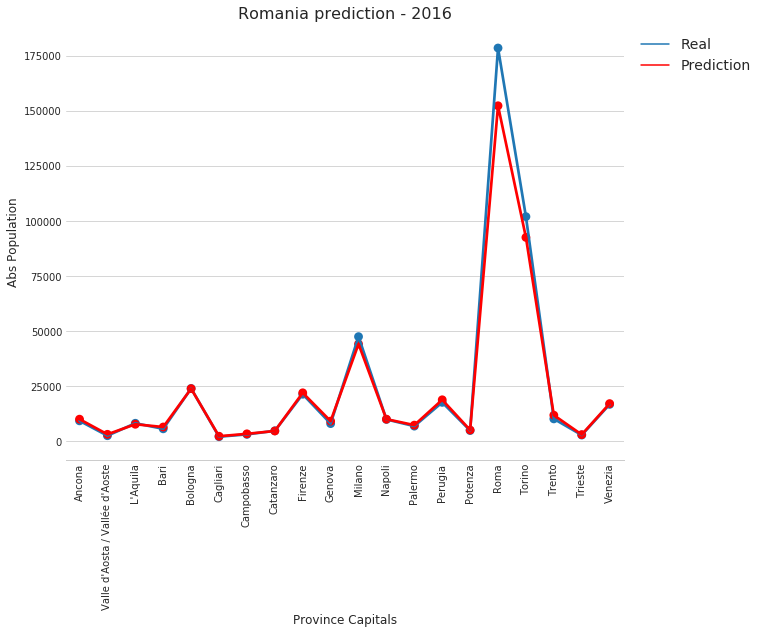

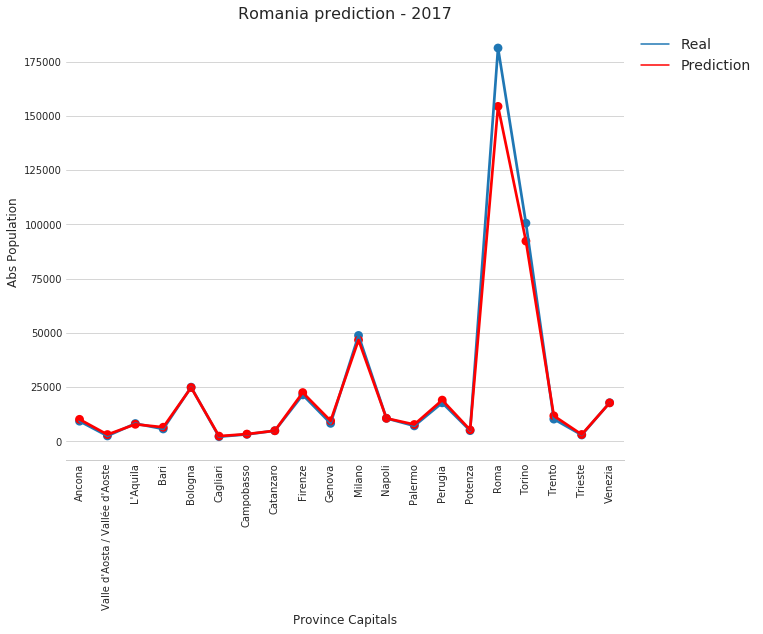

In [42]:
real_vs_prediction(res_rou, data_rou_test, years_test, x_df, "Romania")